# FIFA WORLD CUP 2018 Predictor
The goal of this project is to see if fifa world cup results can be predicted using aggregate team scores assembled from the individual strength of each of the team's players. Then compare the team ratings alongside real game results across the four main european club leagues to train a model.

### Datasets
- Player ratings from the FIFA 18 Video Game
- 2017-2018 Season results for training the model from:
    - English Premiere League
    - German Bundesliga
    - Spanish La Liga
    - Italian Serie A
- World Cup 2018 schedule

In [41]:
#Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam

#Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import tree

In [42]:
from league_team_names import epl_team_dict, bundesliga_team_dict, laliga_team_dict, seriea_teams_dict
country_group_dict = pd.read_csv('data/worldcup_country_groups.csv', ).to_dict
players_df = pd.read_csv('data/fifa-18-demo-player-dataset/CompleteDataset.csv')
epl2018 = pd.read_csv('data/leagues/epl2018.csv')
bundesliga2018 = pd.read_csv('data/leagues/bundesliga2018.csv')
seriea2018 = pd.read_csv('data/leagues/seriea2018.csv')
laliga2018 = pd.read_csv('data/leagues/laliga2018.csv')

/tmp/ipykernel_11/3078856062.py:3: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  players_df = pd.read_csv('data/fifa-18-demo-player-dataset/CompleteDataset.csv')


### Cleaning the Data
First we start with cleaning the dataset containing the detailed stats for each of the FIFA 18 video game's nearly 18,000 players. Each player has 75 columns of attributes. We drop most of the columns are we are concerned in only the player's overall rating and their position.

The distribution of player ratings follows a predictable bell curve, which is to be expected.

In [43]:
print(players_df.shape)
players_df[['Name', 'Overall', 'Preferred Positions']].head()

(17981, 75)


,Name,Overall,Preferred Positions
0,Cristiano Ronaldo,94,ST LW
1,L. Messi,93,RW
2,Neymar,92,LW
3,L. Suárez,92,ST
4,M. Neuer,92,GK


/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


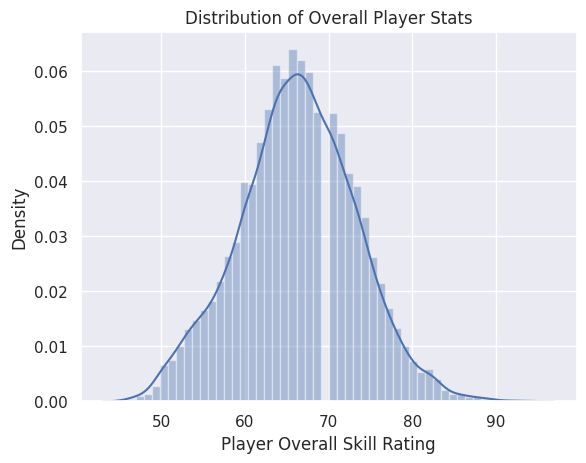

In [44]:
sns.set()
sns.distplot(players_df['Overall'])

plt.title('Distribution of Overall Player Stats')
plt.xlabel('Player Overall Skill Rating')

plt.savefig('player_stats_distribution.png')
plt.show()

Another step in cleaning the data is to group the positions of the players into categories. The idea is to then aggregate the individual scores of each kind of position into three team attributes:
- Attack
- Midfield
- Defense

Then we apply these categories to the player data.

In [45]:
positions_dict = {'ST': 'Attack',
                  'RW': 'Attack',
                  'LW': 'Attack',
                  'GK': 'Defense',
                  'CDM': 'Midfield',
                  'CB': 'Defense',
                  'RM': 'Midfield',
                  'CM': 'Midfield',
                  'LM': 'Midfield',
                  'LB': 'Defense',
                  'CAM': 'Attack',
                  'RB': 'Defense',
                  'CF': 'Attack',
                  'RWB': 'Defense',
                  'LWB': 'Defense'}

player_overall_df = players_df[['Name', 'Club', 'Nationality', 'Preferred Positions', 'Overall']].copy()
player_overall_df['Preferred Positions'] = player_overall_df['Preferred Positions'].apply(lambda x: x.split(' ', 1)[0]).replace(positions_dict)
player_overall_df.head()

,Name,Club,Nationality,Preferred Positions,Overall
0,Cristiano Ronaldo,Real Madrid CF,Portugal,Attack,94
1,L. Messi,FC Barcelona,Argentina,Attack,93
2,Neymar,Paris Saint-Germain,Brazil,Attack,92
3,L. Suárez,FC Barcelona,Uruguay,Attack,92
4,M. Neuer,FC Bayern Munich,Germany,Defense,92


### Aggregating Team Stats
With the individual player data categorized into Attack, Midfield & Defense, we can write the following code that will calculate and output team level ratings. Let's try getting the ratings for a couple teams.

In [46]:
def get_team_stats(team, type='Club', no_of_players=13, return_df=False):
    mask = player_overall_df[type] == team
    groupby_cols = [type, 'Preferred Positions']
    team_stats_df = player_overall_df[mask].head(no_of_players).groupby(groupby_cols).mean().round(0)
    if return_df == True:
        return team_stats_df
    else:
        df = team_stats_df.reset_index().pivot(type, 'Preferred Positions')
        attack = df['Overall'].values[0][0]
        mid = df['Overall'].values[0][1]
        defense = df['Overall'].values[0][2]
        return [attack, mid, defense]

In [47]:
get_team_stats('Portugal', type='Nationality', return_df=True)

Overall
Nationality Preferred Positions         
Portugal    Attack                  86.0
            Defense                 84.0
            Midfield                83.0

In [48]:
get_team_stats('FC Barcelona', type='Club', return_df=True)

Overall
Club         Preferred Positions         
FC Barcelona Attack                  86.0
             Defense                 85.0
             Midfield                86.0

### Building a dataset for training a model
In order to build a dataset for training models, we grab the schedules and results for each of the four main european leagues and merge them into a single dataset.

In [49]:
team_cols = ['HomeTeam', 'AwayTeam']
epl2018[team_cols] = epl2018[team_cols].replace(epl_team_dict)
bundesliga2018[team_cols] = bundesliga2018[team_cols].replace(bundesliga_team_dict)
seriea2018[team_cols] = seriea2018[team_cols].replace(seriea_teams_dict)
laliga2018[team_cols] = laliga2018[team_cols].replace(laliga_team_dict)

results_dict = {'H': 'HomeWin', "D": 'Draw', "A": 'AwayWin'}
cols = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']

league_results_df = pd.concat([epl2018, bundesliga2018, seriea2018, laliga2018])[cols]
league_results_df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR': 'Result'}, inplace=True)
league_results_df['Result'] = league_results_df['Result'].replace(results_dict)
league_results_df['Goal diff'] = league_results_df['HomeGoals'] - league_results_df['AwayGoals']

league_results_df.reset_index(drop=True, inplace=True)
league_results_df

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,Goal diff
0,Arsenal,Leicester City,4,3,HomeWin,1
1,Brighton & Hove Albion,Manchester City,0,2,AwayWin,-2
2,Chelsea,Burnley,2,3,AwayWin,-1
3,Crystal Palace,Huddersfield Town,0,3,AwayWin,-3
4,Everton,Stoke City,1,0,HomeWin,1
...,...,...,...,...,...,...
1441,Villarreal CF,Real Madrid CF,2,2,Draw,0
1442,Athletic Club de Bilbao,RCD Espanyol,0,1,AwayWin,-1
1443,Atlético Madrid,SD Eibar,2,2,Draw,0
1444,FC Barcelona,Real Sociedad,1,0,HomeWin,1


### Taking a look at the training set
Before we move forward, lets take a look at the training dataset to see if there are some patterns we can identify up front from charting the match outcomes and the goal differential.

- Home team advantage is real
    - Home team advantage is an influence that could impact our world cup predictions in some way
- Games are usually close
    - Draws are very likely outcome of matches so this will need to be accounted for in our model
    



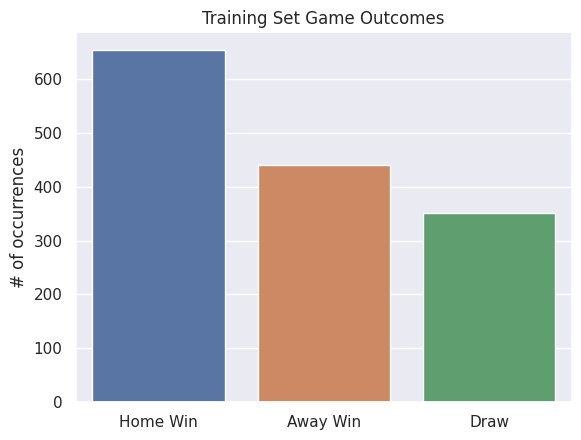

In [50]:
sns.set()

sns.barplot(x=['Home Win', 'Away Win', 'Draw'], y='Result', data=pd.DataFrame(league_results_df['Result'].value_counts()))

plt.title('Training Set Game Outcomes')
plt.ylabel('# of occurrences')


plt.savefig('training_set_outcomes.png')
plt.show()

/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


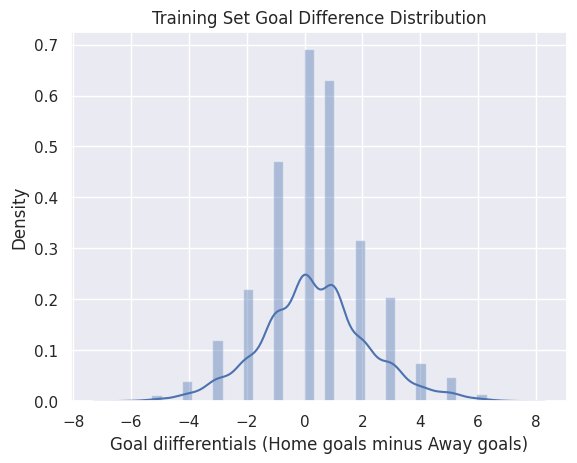

In [51]:
sns.set()

sns.distplot(league_results_df['Goal diff'])

plt.title('Training Set Goal Difference Distribution')
plt.xlabel('Goal diifferentials (Home goals minus Away goals)')


plt.savefig('goal_diff_distribution.png')
plt.show()

To finalize our training dataset we can use the following code to replace the team names with their respective aggregate ratings based on the team's individual players.

In [52]:
homeTeam_attack = []
homeTeam_mid = []
homeTeam_def = []
awayTeam_attack = []
awayTeam_mid = []
awayTeam_def = []
data = []


for index, row in league_results_df.iterrows():
    try:
        home_team_stats = get_team_stats(row['HomeTeam'])
        home_attack = home_team_stats[0]
        home_midfield = home_team_stats[1]
        home_defense = home_team_stats[2]

        away_team_stats = get_team_stats(row['AwayTeam'])
        away_attack = away_team_stats[0]
        away_midfield = away_team_stats[1]
        away_defense = away_team_stats[2]
                
        homeTeam_attack.append(home_attack)
        homeTeam_mid.append(home_midfield)
        homeTeam_def.append(home_defense)
        awayTeam_attack.append(away_attack)
        awayTeam_mid.append(away_midfield)
        awayTeam_def.append(away_defense)

        
    except IndexError:
        homeTeam_attack.append(None)
        homeTeam_mid.append(None)
        homeTeam_def.append(None)
        awayTeam_attack.append(None)
        awayTeam_mid.append(None)
        awayTeam_def.append(None)
        continue
        
data = [homeTeam_attack, 
        homeTeam_mid, 
        homeTeam_def, 
        awayTeam_attack,
        awayTeam_mid, 
        awayTeam_def]

feature_cols = ['homeTeam_attack', 
                'homeTeam_mid', 
                'homeTeam_def', 
                'awayTeam_attack', 
                'awayTeam_mid',
                'awayTeam_def']

home_cols = ['homeTeam_attack', 
                'homeTeam_mid', 
                'homeTeam_def', 
                'awayTeam_attack', 
                'awayTeam_mid',
                'awayTeam_def']

away_cols = ['awayTeam_attack', 
             'awayTeam_mid',
             'awayTeam_def',
             'homeTeam_attack', 
             'homeTeam_mid', 
             'homeTeam_def']

rename_cols = ['A_Team_attack', 
               'A_Team_mid',
               'A_Team_def',
               'B_Team_attack', 
               'B_Team_mid', 
               'B_Team_def']
             

team_ratings_df = pd.DataFrame(data, index=feature_cols)

team_ratings_df = team_ratings_df.transpose()

team_ratings_df['HomeGoals'] = league_results_df['HomeGoals']
team_ratings_df['AwayGoals'] = league_results_df['AwayGoals']
team_ratings_df['result'] = league_results_df['Result']

team_ratings_df.dropna(inplace=True)

team_ratings_df.head()

,homeTeam_attack,homeTeam_mid,homeTeam_def,awayTeam_attack,awayTeam_mid,awayTeam_def,HomeGoals,AwayGoals,result
0,85.0,83.0,83.0,80.0,78.0,78.0,4,3,HomeWin
1,76.0,75.0,75.0,89.0,83.0,85.0,0,2,AwayWin
2,86.0,85.0,84.0,75.0,77.0,75.0,2,3,AwayWin
3,78.0,76.0,79.0,75.0,73.0,74.0,0,3,AwayWin
4,81.0,81.0,82.0,78.0,79.0,77.0,1,0,HomeWin


### Separate the Training set into X and Y
- X represents the team ratings 
- y represents the match outcome (variable we want to predict)

Both X & y must have the same length. In our case that is 1446 rows of match data. Since the model needs to use numerical data, we remap a home win to "2", a draw to "1" and an away team win to "0" to fulfill that requirement.

In [53]:
X = team_ratings_df[feature_cols]
print(X.shape)
X.head()

(1446, 6)


,homeTeam_attack,homeTeam_mid,homeTeam_def,awayTeam_attack,awayTeam_mid,awayTeam_def
0,85.0,83.0,83.0,80.0,78.0,78.0
1,76.0,75.0,75.0,89.0,83.0,85.0
2,86.0,85.0,84.0,75.0,77.0,75.0
3,78.0,76.0,79.0,75.0,73.0,74.0
4,81.0,81.0,82.0,78.0,79.0,77.0


In [54]:
result_mapping_dict = {'HomeWin': 2, 'Draw': 1, 'AwayWin': 0}
y = pd.DataFrame(league_results_df['Result']).reset_index(drop=True).replace(result_mapping_dict)
print(y.shape)
y.head()

(1446, 1)


,Result
0,2
1,0
2,0
3,0
4,2


Take the training set and split off a quarter of the data to use for validation and accuracy measurement.

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1084, 6)
(1084, 1)
(362, 6)
(362, 1)


### Machine Learning
Time to train the models! We will start with three common models, linear regression, logistic regression and a decision tree classification model. The code below uses the same training set for all three models and performs fit calculations in order to build a prediction model.

In [56]:
linreg = LinearRegression()
logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, y_train)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)
logreg.fit(X_train, y_train)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

### Machine Predictions
After fitting and creating the three models, we can then unleash the predictions on our test datasets and compare the accuracy.

How did each model do compared to real life? The following functions will calculate that for us.

In [57]:
def get_numbers_from_array(array):
    nums = []
    for n in array:
        try:
            nums.append(n[0])
        except:
            nums.append(n)
    return nums

def normalize_test_model(y):
    if y > (4/3):
        return 2
    elif y < (2/3):
        return 0
    else:
        return 1
    
def compare_accuracy(df):
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0

    for index, row in df.iterrows():
        if row['lin Reg'] == row['actual results']:
            count1 += 1
        else:
            continue
        if row['log Reg'] == row['actual results']:
            count2 += 1
        else:
            continue
        if row['clf'] == row['actual results']:
            count3 += 1
        else:
            continue

    print('Linear Reg Model: {}% accurate'.format(round(count1 / len(test_model_df), 2)*100))
    print('Logistic Reg Model: {}% accurate'.format(round(count2 / len(test_model_df), 2)*100))
    print('Classification Model: {}% accurate'.format(round(count3 / len(test_model_df), 2)*100))
linreg_y_pred = linreg.predict(X_test)
logreg_y_pred = logreg.predict(X_test)
clf_y_pred = clf.predict(X_test)
    
linreg_y_pred = get_numbers_from_array(linreg_y_pred)
logreg_y_pred = get_numbers_from_array(logreg_y_pred)
clf_y_pred = get_numbers_from_array(clf_y_pred)

ml_data = [linreg_y_pred, logreg_y_pred, clf_y_pred]

test_model_df = pd.DataFrame(ml_data, 
                             index=['lin Reg', 'log Reg', 'clf']).transpose()

test_model_df['actual results'] = list(y_test['Result'])
test_model_df['lin Reg'] = test_model_df['lin Reg'].apply(normalize_test_model)

compare_accuracy(test_model_df)

Linear Reg Model: 44.0% accurate
Logistic Reg Model: 26.0% accurate
Classification Model: 19.0% accurate


Seems the Linear Regression Model had the best performance however 44% is not that accurate.

### Poisson Distribution
Poisson distributions represent the probability of a given number of events occurring in a fixed time if these events occur independently of the time since the last event. This somewhat matches the inherent randomness of the time that goals are scored in a soccer match. Lets see if we can use our training dataset again to train a Poisson distribution model that uses the team stats as inputs.

Here we have to use the goal count as the y value since Poisson calculates the probabilities of goals scored, instead of overall winner/loser. After we get a way to generate the probabilites of goals, we can later predict match outcomes.

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

home_team_df = team_ratings_df[home_cols].copy()
home_team_df.columns = rename_cols
away_team_df = team_ratings_df[away_cols].copy()
away_team_df.columns = rename_cols

X = pd.concat([home_team_df, away_team_df]).reset_index(drop=True)

y = pd.DataFrame(pd.concat([team_ratings_df['HomeGoals'], team_ratings_df['AwayGoals']]).reset_index(drop=True), columns=['goals'])

goal_model_data = X.join(y)

goal_model_data.head()

,A_Team_attack,A_Team_mid,A_Team_def,B_Team_attack,B_Team_mid,B_Team_def,goals
0,85.0,83.0,83.0,80.0,78.0,78.0,4
1,76.0,75.0,75.0,89.0,83.0,85.0,0
2,86.0,85.0,84.0,75.0,77.0,75.0,2
3,78.0,76.0,79.0,75.0,73.0,74.0,0
4,81.0,81.0,82.0,78.0,79.0,77.0,1


Now plug in the training dataset into the poisson model and output the model summary.

In [59]:
poisson_model = smf.glm(formula="goals ~ A_Team_attack + A_Team_mid + A_Team_def + B_Team_attack + B_Team_mid + B_Team_def", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2892
Model:                            GLM   Df Residuals:                     2885
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4221.6
Date:                Mon, 05 Sep 2022   Deviance:                       3404.4
Time:                        08:06:11   Pearson chi2:                 3.01e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1339
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.6821      0.507     -3.317      0.001      -2.676      -0.688
A_Team_attack     0.0434      0.011      3.934      0.000       0.022       0.065
A_Team_mid        0.0020      0.012      0.170      0.865      -0.021       0.025
A_Team_def        0.0259      0.012      2.113      0.035       0.002       0.050
B_Team_attack    -0.0129      0.011     -1.149      0.250      -0.035       0.009
B_Team_mid       -0.0359      0.012     -2.903      0.004      -0.060      -0.012
B_Team_def        0.0020      0.013      0.155      0.877      -0.023       0.027
=================================================================================
"""

### Running Game Simulations
Will the poisson model output something realistic if we plug the world cup teams?

In [60]:
def simulate_goals(game, a_team='A Team', b_team='B Team', verbose=False):
    a_goals = 0
    b_goals = 0
    outcome = 0

    random_event = np.random.random()
    counter = 0


    for index, row in pd.DataFrame(data=game).iterrows():
        for x in range(len(row)):
            counter += row[x]
            
            a_goals = index
            b_goals = x
            
            if counter > random_event:
                break
        if counter > random_event:
            break
    
    if verbose == True:
        print('Random float: {}'.format(random_event))
        print('{} goals: {}'.format(a_team, str(a_goals)))
        print('{} goals: {}\n'.format(b_team, str(b_goals)))
    
    return a_goals, b_goals


def show_game_summary(game, a_team='A Team', b_team='B Team', verbose=False):
    a_team_odds = np.sum(np.tril(game, -1))
    b_team_odds = np.sum(np.triu(game, 1))
    draw_odds = np.sum(np.diag(game))
    
    if verbose == True:
        print('{} chance of Win: {}%'.format(a_team, round(a_team_odds*100, 2)))
        print('{} chance of Win: {}%'.format(b_team, round(b_team_odds*100, 2)))
        print('Odds of a draw: {}%'.format(round(draw_odds*100, 2)))
    
    a_goals, b_goals = simulate_goals(game, a_team, b_team, verbose=verbose)
    
    return a_team_odds, b_team_odds, draw_odds, a_goals, b_goals


def simulate_match(foot_model, a_team, b_team, type='Club', max_goals=9, verbose=False):
    a_team_stats = get_team_stats(a_team, type=type)
    b_team_stats = get_team_stats(b_team, type=type)
    
    data1 = {'A_Team_attack': a_team_stats[0],
              'A_Team_mid': a_team_stats[1],
              'A_Team_def': a_team_stats[2],
              'B_Team_attack': b_team_stats[0], 
              'B_Team_mid': b_team_stats[1], 
              'B_Team_def': b_team_stats[2]}
    
    data2 = {'A_Team_attack': b_team_stats[0],
              'A_Team_mid': b_team_stats[1],
              'A_Team_def': b_team_stats[2],
              'B_Team_attack': a_team_stats[0], 
              'B_Team_mid': a_team_stats[1], 
              'B_Team_def': a_team_stats[2]}
        
    a_goals_avg = foot_model.predict(pd.DataFrame(data=data1, index=[1])).values[0]
    b_goals_avg = foot_model.predict(pd.DataFrame(data=data2, index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [a_goals_avg, b_goals_avg]]
    game = (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
    show_game_summary(game, a_team, b_team, verbose=verbose)
    return game


### Spain vs Iran

We can see that Spain is rated much higher than Iran in all team metrics. According to our poisson model, Spain is predicted to win 89% of the time. Its also more likely that Iran ties Spain than outright wins. This seems realistic as Spain is a very strong team with alot of goal scoring potential.

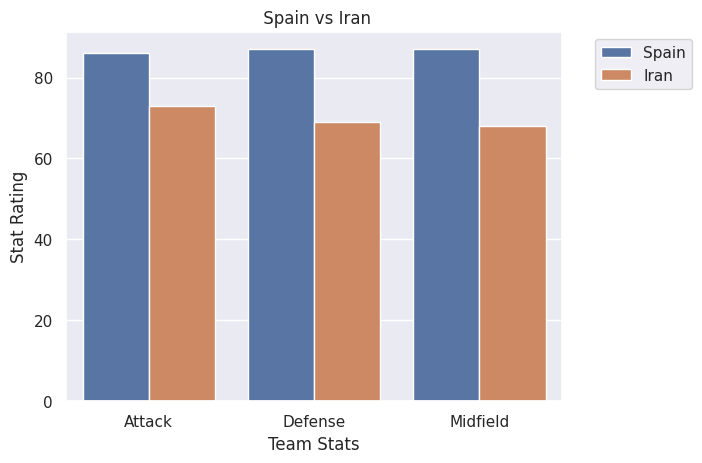

In [61]:
get_team_stats('Spain', type='Nationality', return_df=True)

data = pd.concat([get_team_stats('Spain', type='Nationality', return_df=True).reset_index(), get_team_stats('Iran', type='Nationality', return_df=True).reset_index()])

sns.barplot(x='Preferred Positions', y='Overall', hue='Nationality', data=data)
plt.title(' Spain vs Iran')
plt.xlabel('Team Stats')
plt.ylabel('Stat Rating')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.savefig('spain_vs_iran.png', bbox_inches='tight')
plt.show()

In [62]:
game = simulate_match(poisson_model, 'Spain', 'Iran', type='Nationality')
show_game_summary(game, 'Spain', 'Iran', verbose=True)

Spain chance of Win: 88.98%
Iran chance of Win: 2.96%
Odds of a draw: 7.85%
Random float: 0.5024629572012826
Spain goals: 3
Iran goals: 1



(0.8897511047391461, 0.02958116448932703, 0.07849130091609727, 3, 1)

### How does a Poisson Model work?
The model outputs an array of probabilities with each value corresponding to a match outcome. An example would be that value in colum 0, row 3 is 13%. That means there is a 13% chance Spain wins 3 to 0.

The chances of a draw is the sum of values along the diagonal and the chances for either team is the sum of the array either above or below the diagonal.

In [63]:
pd.DataFrame(game)

,0,1,2,3,4,5,6,7,8,9
0,0.022260,0.011326,0.002882,0.000489,0.000062,6.327024e-06,5.365627e-07,3.900270e-08,2.480715e-09,1.402512e-10
1,0.073371,0.037333,0.009498,0.001611,0.000205,2.085480e-05,1.768590e-06,1.285586e-07,8.176802e-09,4.622886e-10
2,0.120921,0.061528,0.015654,0.002655,0.000338,3.437025e-05,2.914766e-06,2.118741e-07,1.347597e-08,7.618857e-10
3,0.132858,0.067602,0.017199,0.002917,0.000371,3.776314e-05,3.202499e-06,2.327894e-07,1.480626e-08,8.370958e-10
4,0.109480,0.055707,0.014173,0.002404,0.000306,3.111822e-05,2.638977e-06,1.918271e-07,1.220091e-08,6.897978e-10
5,0.072172,0.036723,0.009343,0.001585,0.000202,2.051405e-05,1.739692e-06,1.264580e-07,8.043197e-09,4.547350e-10
6,0.039649,0.020174,0.005133,0.000871,0.000111,1.126955e-05,9.557133e-07,6.947073e-08,4.418594e-09,2.498123e-10
7,0.018670,0.009500,0.002417,0.000410,0.000052,5.306587e-06,4.500246e-07,3.271225e-08,2.080619e-09,1.176312e-10
8,0.007692,0.003914,0.000996,0.000169,0.000021,2.186411e-06,1.854184e-07,1.347805e-08,8.572535e-10,4.846620e-11
9,0.002817,0.001433,0.000365,0.000062,0.000008,8.007482e-07,6.790738e-08,4.936182e-09,3.139593e-10,1.775019e-11


In [64]:
np.sum(game)

0.9978235701445703

### Spain vs Portugal

How does the model change when we pair up similarly strong teams?

While Spain is still the strong team on paper, this matchup is far more even. The poisson model predicts a far more balanced outcome with Spain winning 45% of the time, Portugal winning 31% and a chance of a draw is almost 1 out of 4 games. These results are fairly rational.

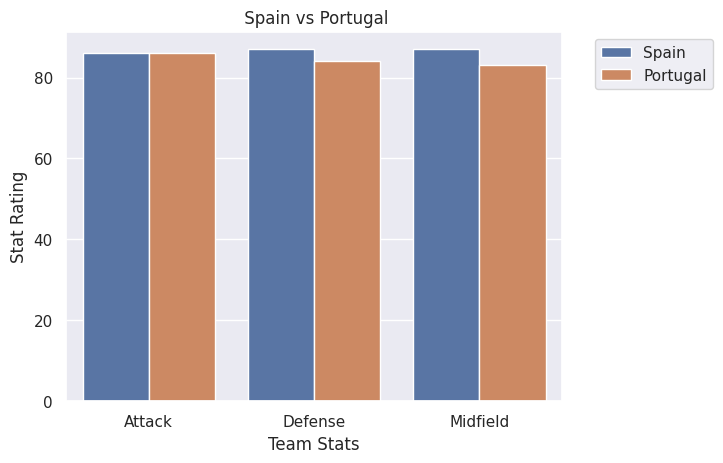

In [65]:
data = pd.concat([get_team_stats('Spain', type='Nationality', return_df=True).reset_index(), get_team_stats('Portugal', type='Nationality', return_df=True).reset_index()])

sns.barplot(x='Preferred Positions', y='Overall', hue='Nationality', data=data)
plt.title(' Spain vs Portugal')
plt.xlabel('Team Stats')
plt.ylabel('Stat Rating')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig('spain_vs_portugal.png', bbox_inches='tight')
plt.show()

In [66]:
game = simulate_match(poisson_model, 'Spain', 'Portugal', type='Nationality')
show_game_summary(game, 'Spain', 'Portugal', verbose=True)

Spain chance of Win: 44.99%
Portugal chance of Win: 31.19%
Odds of a draw: 23.82%
Random float: 0.040733430283471095
Spain goals: 0
Portugal goals: 0



(0.44992463700040786, 0.31189321552861926, 0.23816980540193733, 0, 0)

### Simulating a World Cup
Now that we have a reasonable model, Now working on simulating a live world cup, including all the inherent randomness. First, start off by getting the schedule data for the group stage and writing some code to apply the poisson model.

In [68]:
schedule_df = pd.read_csv('data/worldcup_match_schedule.csv')
schedule_df.head()

,a_team,b_team
0,Russia,Saudi Arabia
1,Egypt,Uruguay
2,Portugal,Spain
3,Morocco,Iran
4,France,Australia


In [69]:
def get_game_summary(df):

    a_team_odds = []
    b_team_odds = []
    draw_odds = []
    a_goals_count = []
    b_goals_count = []

    for index, row in schedule_df.iterrows():
        a_team = row[0]
        b_team = row[1]

        game = simulate_match(poisson_model, a_team, b_team, type='Nationality')
        a_team_probability, b_team_probability, draw_probability, a_goals, b_goals  = show_game_summary(game)

        a_team_odds.append(a_team_probability)
        b_team_odds.append(b_team_probability)
        draw_odds.append(draw_probability)
        a_goals_count.append(a_goals)
        b_goals_count.append(b_goals)
        
    
    df['a_team_chances'] = pd.Series(a_team_odds)
    df['b_team_chances'] = pd.Series(b_team_odds)
    df['draw_chances'] = pd.Series(draw_odds)
    df['a_goals'] = pd.Series(a_goals_count)
    df['b_goals'] = pd.Series(b_goals_count)
    
    return df


def calculate_stage_winner(df):
    a_team_points = []
    b_team_points = []

    for index, row in group_stage_results_df.iterrows():
        win = 3
        loss = 0
        draw = 1
        if row['a_goals'] == row['b_goals']:
            a_team_points.append(draw)
            b_team_points.append(draw)
        elif row['a_goals'] > row['b_goals']:
            a_team_points.append(win)
            b_team_points.append(loss)
        elif row['a_goals'] < row['b_goals']:
            a_team_points.append(loss)
            b_team_points.append(win)


        df['a_points'] = pd.Series(a_team_points)
        df['b_points'] = pd.Series(b_team_points)
        
    return df

In [70]:
schedule_df = pd.read_csv('data/worldcup_match_schedule.csv')

group_stage_results_df = get_game_summary(schedule_df)
group_stage_results_df = calculate_stage_winner(group_stage_results_df)
group_stage_results_df

,a_team,b_team,a_team_chances,b_team_chances,draw_chances,a_goals,b_goals,a_points,b_points
0,Russia,Saudi Arabia,0.554290,0.202677,0.243023,2,1,3,0
1,Egypt,Uruguay,0.128553,0.675456,0.195929,2,1,3,0
2,Portugal,Spain,0.311893,0.449925,0.238170,0,0,1,1
3,Morocco,Iran,0.632917,0.147130,0.219929,2,2,1,1
4,France,Australia,0.783094,0.075025,0.141530,3,0,3,0
5,Peru,Denmark,0.210984,0.542639,0.246369,1,1,1,1
6,Argentina,Iceland,0.823846,0.058962,0.116335,3,3,1,1
7,Croatia,Nigeria,0.597850,0.175881,0.226247,2,0,3,0
8,Brazil,Switzerland,0.611717,0.175833,0.212408,1,1,1,1
9,Costa Rica,Serbia,0.214069,0.543399,0.242522,1,2,0,3


Above you can see the full details of each group stage match including the probabilites of each outcome. Additionally simulated a round by predicting goals and awarding group stage points based on the match outcomes. Below we can sum up the initial group stage results to see which teams move onto the knockout stage.

In [71]:
cols = {'a_team': 'Team', 'a_goals': 'Goals', 'a_points': 'Points',
        'b_team': 'Team', 'b_goals': 'Goals', 'b_points': 'Points'}

a_team_group_results_df = group_stage_results_df[['a_team', 'a_goals', 'a_points']].rename(columns=cols)
b_team_group_results_df = group_stage_results_df[['b_team', 'b_goals', 'b_points']].rename(columns=cols)

scoreboard_df = pd.concat([a_team_group_results_df, b_team_group_results_df]).reset_index(drop=True)
scoreboard_df = scoreboard_df.merge(pd.read_csv('data/worldcup_country_groups.csv'), on='Team', how='left')
scoreboard_df = scoreboard_df.groupby(['Group', 'Team']).sum().reset_index()
scoreboard_df = scoreboard_df.sort_values(['Group', 'Points', 'Goals'], ascending=[True, False, False]).reset_index(drop=True)
scoreboard_df

,Group,Team,Goals,Points
0,A,Uruguay,6,6
1,A,Russia,4,6
2,A,Saudi Arabia,4,3
3,A,Egypt,3,3
4,B,Spain,6,7
5,B,Iran,3,4
6,B,Portugal,1,4
7,B,Morocco,3,1
8,C,France,11,9
9,C,Denmark,2,4


### Knock out stage
After the group stage, the world cup moves onto a knockout format. This stage follows the same schedule every time, however the teams that play in each match does matter based on the group stage outcomes. The following code will simulate the schedule.

In [77]:
round_of_16_games = [(0, 5), (8, 13),
                     (16, 21), (24, 29),
                     (4, 1), (12, 9),
                     (20, 17), (28, 25)]

round_of_8_games = [(0, 1), (2, 3),
                     (4, 5), (6, 7)]

round_of_4_games = [(0, 1), (2, 3)]

round_of_2_games = [(0, 1)]

Since draws are so common, we have some code to compare the penalty stats for teams in the event of a draw.

In [78]:
def get_team_penalties(team):
    mask = players_df['Nationality'] == team
    return pd.to_numeric(players_df[mask]['Penalties'].head(), errors='coerce').mean()

def simulate_penalties(a_team, b_team):
    a_pen = get_team_penalties(a_team)
    b_pen = get_team_penalties(b_team)
    
    if a_pen == b_pen:
        winner = a_team
    elif a_pen > b_pen:
        winner = a_team
    elif a_pen < b_pen:
        winner = b_team
    
    return winner

We can write code to simulate an entire world cup, from group stage through to the final winner.

In [79]:
def get_knockout_winner(round_results_df):
    winners = []
    
    for index, row in round_results_df.iterrows():
        if row['a_goals'] == row['b_goals']:
            winner = simulate_penalties(row[0], row[1])
        elif row['a_goals'] > row['b_goals']:
            winner = row[0]
        elif row['a_goals'] < row['b_goals']:
            winner = row[1]
            
        winners.append(winner)
        
    round_results_df['Winner'] = pd.Series(winners)
    
    return round_results_df
    

def simulate_knockout_stage(df, schedule_tuples):
    a_team_lists = []
    b_team_lists = []

    a_team_odds = []
    b_team_odds = []
    draw_odds = []
    a_goals_count = []
    b_goals_count = []
    
    
    for match in schedule_tuples:
        a_team = df.iloc[match[0]]['Team']
        b_team = df.iloc[match[1]]['Team']
        a_team_lists.append(a_team)
        b_team_lists.append(b_team)

        game = simulate_match(poisson_model, a_team, b_team, type="Nationality")
        a_team_probability, b_team_probability, draw_probability, a_goals, b_goals  = show_game_summary(game)

        a_team_odds.append(a_team_probability)
        b_team_odds.append(b_team_probability)
        draw_odds.append(draw_probability)
        a_goals_count.append(a_goals)
        b_goals_count.append(b_goals)

    round_results_df = pd.DataFrame([a_team_lists, b_team_lists]).transpose()
    round_results_df = get_game_summary(round_results_df)
    round_results_df = get_knockout_winner(round_results_df)
    
    df = pd.DataFrame(round_results_df['Winner']).rename(columns={'Winner': 'Team'})    
    
    return df

def simulate_World_Cup(n_simulations=None, verbose=False):
    world_cup_winners = []
    n = 0
    while n < n_simulations:
        try:
            group_stage_results_df = get_game_summary(schedule_df)
            group_stage_results_df = calculate_stage_winner(group_stage_results_df)

            cols = {'a_team': 'Team', 'a_goals': 'Goals', 'a_points': 'Points',
                    'b_team': 'Team', 'b_goals': 'Goals', 'b_points': 'Points'}

            a_team_group_results_df = group_stage_results_df[['a_team', 'a_goals', 'a_points']].rename(columns=cols)
            b_team_group_results_df = group_stage_results_df[['b_team', 'b_goals', 'b_points']].rename(columns=cols)

            scoreboard_df = pd.concat([a_team_group_results_df, b_team_group_results_df]).reset_index(drop=True)
            scoreboard_df = scoreboard_df.merge(pd.read_csv('data/worldcup_country_groups.csv'), on='Team', how='left')
            scoreboard_df = scoreboard_df.groupby(['Group', 'Team']).sum().reset_index()
            scoreboard_df = scoreboard_df.sort_values(['Group', 'Points', 'Goals'], ascending=[True, False, False])

            df_8 = simulate_knockout_stage(scoreboard_df, round_of_16_games)
            df_4 = simulate_knockout_stage(df_8, round_of_8_games)
            df_2 = simulate_knockout_stage(df_4, round_of_4_games)
            world_cup_winner = simulate_knockout_stage(df_2, round_of_2_games).iloc[0].item()

            world_cup_winners.append(world_cup_winner)
            
            if verbose == True:
                print(group_stage_results_df)
                print(scoreboard_df)
                print(df_8)
                print(df_4)
                print(df_2)
                print(pd.Series(world_cup_winners).value_counts())
                
            print('The winner of World Cup 2018 simulation {}/{} is {}'.format(n+1, n_simulations, world_cup_winner))
            

            n += 1
        except:
            print('Exception occured')
            break
        
    return pd.Series(world_cup_winners).value_counts()

## World cup simulation
Running a world cup simulation

In [80]:
simulate_World_Cup(1, verbose=True)

            a_team          b_team  a_team_chances  b_team_chances  \
0           Russia    Saudi Arabia        0.554290        0.202677   
1            Egypt         Uruguay        0.128553        0.675456   
2         Portugal           Spain        0.311893        0.449925   
3          Morocco            Iran        0.632917        0.147130   
4           France       Australia        0.783094        0.075025   
5             Peru         Denmark        0.210984        0.542639   
6        Argentina         Iceland        0.823846        0.058962   
7          Croatia         Nigeria        0.597850        0.175881   
8           Brazil     Switzerland        0.611717        0.175833   
9       Costa Rica          Serbia        0.214069        0.543399   
10         Germany          Mexico        0.657188        0.150520   
11          Sweden  Korea Republic        0.518825        0.238300   
12         Belgium          Panama        0.923147        0.015909   
13         Tunisia  

Spain    1
dtype: int64

Running World Cup Simulation 1000 times

In [83]:
#world_cup_results = simulate_World_Cup(1000, verbose=False)
#world_cup_results

## Winner Probabilities
Results from running the world cup simulation 1000 times

- Argentina         127
- Belgium            88
- Germany            87
- England            86
- Croatia            73
- Mexico             60
- Sweden             57
- Uruguay            56
- Portugal           54
- Colombia           54
- Spain              43
- Morocco            33
- Egypt              23
- Japan              23
- Russia             23
- Brazil             23
- Iceland            16
- France             14
- Nigeria            12
- Poland              9
- Senegal             8
- Korea Republic      7
- Saudi Arabia        6
- Denmark             5
- Serbia              4
- Peru                4
- Iran                3
- Costa Rica          2